In [3]:
import numpy as np
import gudhi as gd  
import gudhi.representations
import pickle as pickle
from pylab import *
from sklearn.neighbors import KernelDensity
import seaborn as sns
%matplotlib inline
from skimage import io
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import json
from scipy import ndimage

# Test with one image

In [2]:
image = io.imread( "http://ecx.images-amazon.com/images/I/41EpRmh8MEL._SY300_.jpg" )
grayscale_image = rgb2gray(image)

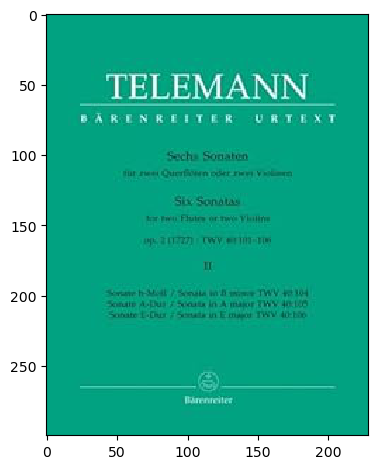

In [3]:
io.imshow(image)

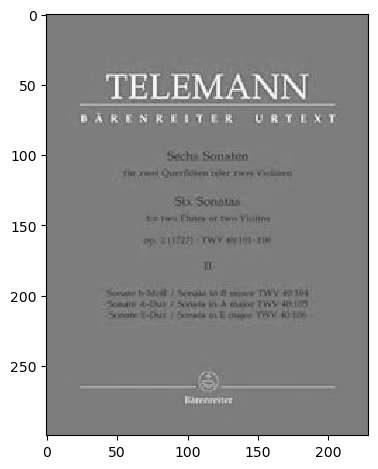

In [4]:
io.imshow(grayscale_image)

In [5]:
print(image.shape, grayscale_image.shape)

(300, 229, 3) (300, 229)


In [6]:
flat_grayscale_image = grayscale_image.flatten()
print(flat_grayscale_image.shape)

(68700,)


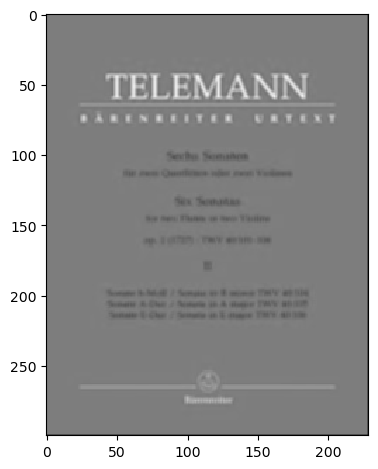

In [34]:
convolve = np.array([[1,1,1],[1,1,1],[1,1,1]])

convolved = ndimage.convolve(grayscale_image, convolve, mode='constant', cval=0.0)
convolved = convolved/9

io.imshow(convolved)

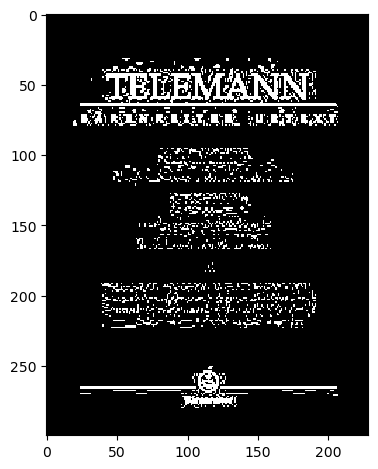

In [37]:
treshold = 0.5
binarized_image = grayscale_image > treshold

io.imshow(binarized_image)

### Calcular persistència utilitzant cubical complexes
1. Calcular Cubical Complex - https://en.wikipedia.org/wiki/Cubical_complex Representació com a punts segments, quadrats, cubs...

   Passo la imatge en dues dimensions com a cel·les: https://gudhi.inria.fr/python/latest/cubical_complex_user.html

In [7]:
cc = gd.CubicalComplex(dimensions = grayscale_image.shape, top_dimensional_cells = flat_grayscale_image)

In [8]:
print("Type:", type(cc), "- Dimension:", cc.dimension(), "- Num simplices:", cc.num_simplices())

Type: <class 'gudhi.cubical_complex.CubicalComplex'> - Dimension: 2 - Num simplices: 275859


2. Calcular persistència homològica

   https://gudhi.inria.fr/python/latest/cubical_complex_ref.html

usetex mode requires TeX.


Text(0.5, 1.0, 'Persistence diagram of the Cubical complex')

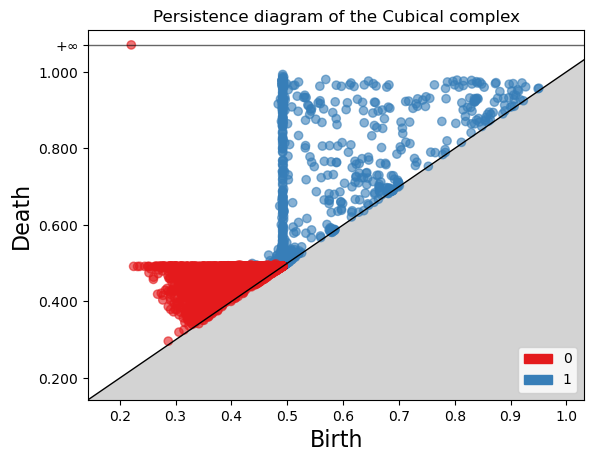

In [9]:
persistence = cc.persistence()  

# diagram
gd.plot_persistence_diagram(persistence)                    
plt.title('Persistence diagram of the Cubical complex')

3.0 Filtració DTM amb un $m\in[0,1)$

The **DTM-filtration** is a filtration of the Euclidean space $\mathbb{R}^n$, based on a finite point cloud $X \subset \mathbb{R}^n$, and two parameters: $m \in [0,1)$ and $p \in [1, +\infty]$. The parameter $m$ corresponds to the DTM and the parameter $p$ corresponds to the radius functions. 
The DTM-filtration is a particular case of the weighted Čech filtrations.

Let $\mu$ denote the empirical probability measure on $X$, and $\mathrm{d}_{\mu,m}\colon \mathbb{R}^n\rightarrow[0, +\infty)$ the DTM on $\mu$ with parameter $m$.
The DTM-filtration $W[X,m,p]$ is defined as the collection of subsets $(W^t[X,m,p])_{t \geq 0}$ where
$$W^t[X,m,p] = \bigcup_{x \in X} \overline{\mathcal{B}}\big(x,(t^p - \mathrm{d}_{\mu,m}^p(x))^\frac{1}{p}\big),$$
and where $\overline{\mathcal{B}}(x,r)$ denotes the closed ball of center $x$ and radius $r$ if $r \geq 0$, or the emptyset if $r < 0$.


Text(0.5, 1.0, 'Values of the DTM on X with parameter m=0.1')

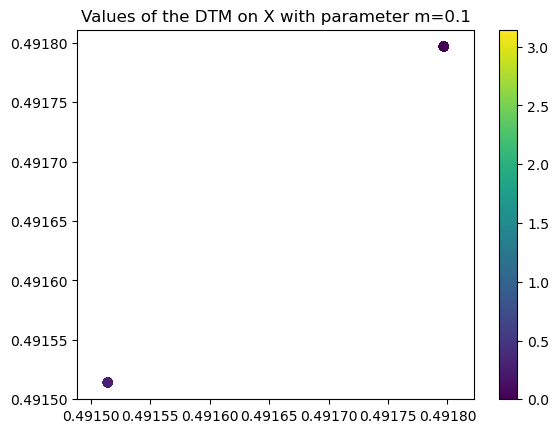

In [10]:
from DTM_filtrations import *

' Compute the DTM on X ' 
# compute the values of the DTM of parameter m
m = 0.1                            
DTM_values = DTM(grayscale_image,grayscale_image,m)             

# plot of the DTM
plot=plt.scatter(grayscale_image[:,0], grayscale_image[:,1], c=DTM_values)
plt.colorbar(plot)
plt.axis('equal')
plt.title('Values of the DTM on X with parameter m='+str(m))

3. Calcular filtració
   
   Podem fer servir la de la llibreria (p=1)

Text(0.5, 1.0, 'Persistence diagram of the DTM-filtration with parameter p = 1')

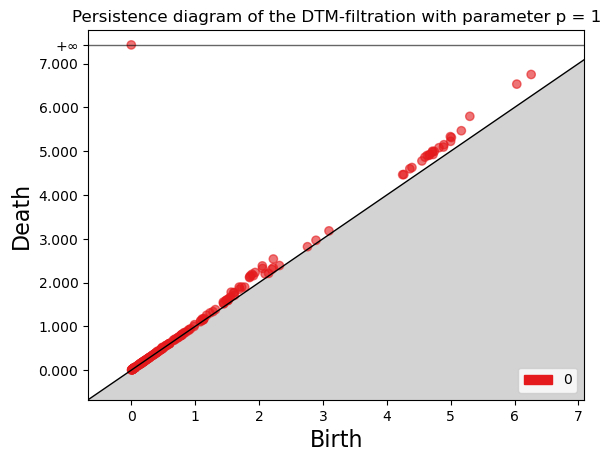

In [11]:
from gudhi.dtm_rips_complex import *

m = 0.1               # parameter of the DTM
N = np.shape(grayscale_image)[0]    # number of points
k = int(m*N)          # parameter of the DTMRipsComplex in gudhi

dtm_rips = gd.dtm_rips_complex.DTMRipsComplex(points=grayscale_image, k=k)  # DTM-Filtration in gudhi
st_DTM = dtm_rips.create_simplex_tree(max_dimension=2)
diagram_DTM = st_DTM.persistence()                               # compute the persistence diagram

# plot the persistence diagram
gd.plot_persistence_diagram(diagram_DTM)
plt.title('Persistence diagram of the DTM-filtration with parameter p = 1')

O qualsevol altre valor pel parametre $p \in [1, +\infty]$.

C:\Users\Esther\Documents\GitHub\TDA-TFG\DTM_filtrations.py:75: RuntimeWarning: invalid value encountered in double_scalars
  g = (I**p-fx**p)**(1/p)+(I**p-fy**p)**(1/p)


Weighted Rips Complex is of dimension 2 - 4500250 simplices - 300 vertices. Filtration maximal value is inf.


Text(0.5, 1.0, 'Persistence diagram of the DTM-filtration with parameter p =5')

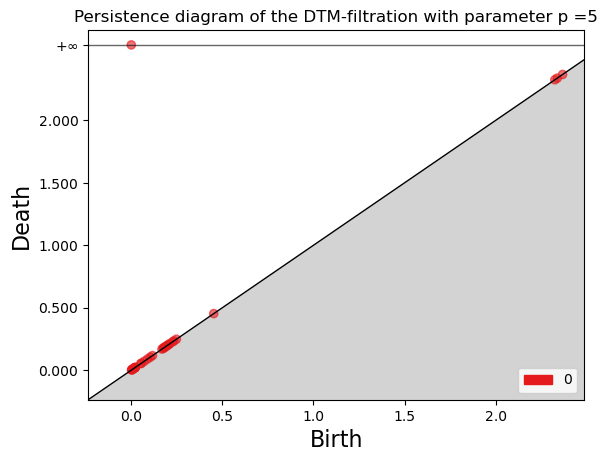

In [12]:
' Compute a DTM-filtration '
p = 5                                             
dimension_max = 2                               # maximal dimension to expand the complex
st_DTM = DTMFiltration(grayscale_image, m, p, dimension_max)  # creating a simplex tree
diagram_DTM = st_DTM.persistence()              # compute the persistence diagram

# plot the persistence diagram
gudhi.plot_persistence_diagram(diagram_DTM)
plt.title('Persistence diagram of the DTM-filtration with parameter p ='+str(p))

### Calcular descriptors
1. Persistència total

In [13]:
persistence_0 = cc.persistence_intervals_in_dimension(0)  #intervals de persistencia de dimensio 0
persistence_1 = cc.persistence_intervals_in_dimension(1)  #intervals de persistencia de dimensio 1

<AxesSubplot:title={'center':'Persistence barcode'}>

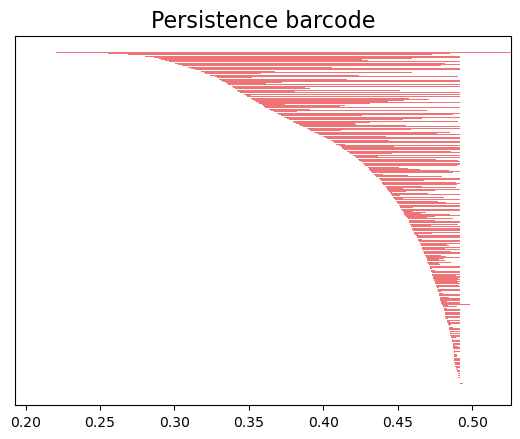

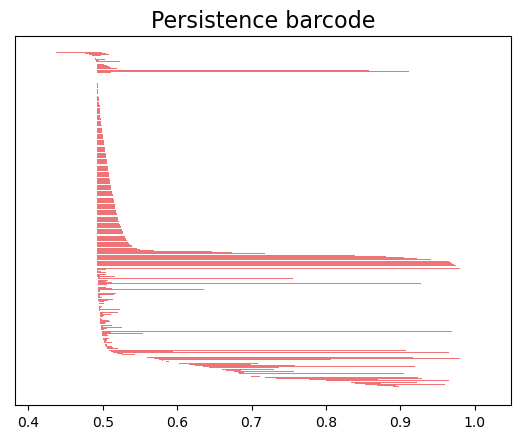

In [14]:
gd.plot_persistence_barcode(persistence_0)
gd.plot_persistence_barcode(persistence_1)

In [15]:
persistence_0_no_inf = np.array([bars for bars in persistence_0 if bars[1]!= np.inf])
persistence_1_no_inf = np.array([bars for bars in persistence_1 if bars[1]!= np.inf])

### Calcular descriptors
https://gudhi.inria.fr/python/latest/#topological-descriptors-computation

https://gudhi.inria.fr/python/latest/representations.html
1. Persistència total

In [16]:
pt_0 = np.sum(np.fromiter( (interval[1] - interval[0] for interval in persistence_0_no_inf), dtype=np.dtype(np.float64)))
pt_1 = np.sum(np.fromiter( (interval[1] - interval[0] for interval in persistence_1_no_inf), dtype=np.dtype(np.float64)))
print("Persistència total de dimensió 0:", pt_0)
print("Persistència total de dimensió 1:", pt_1)

Persistència total de dimensió 0: 128.97852549019606
Persistència total de dimensió 1: 162.40837450980396


2. PE (Entropia persistent) https://github.com/GUDHI/TDA-tutorial/blob/master/Tuto-GUDHI-persistent-entropy.ipynb

We use the representations.Entropy method. When applied to a list of barcodes, it gives another list with their respective persistent entropys.

In [17]:
PE = gd.representations.Entropy()
pe_0 = PE.fit_transform([persistence_0_no_inf])
pe_1 = PE.fit_transform([persistence_1_no_inf])
print("Entropia dimensio 0", pe_0)
print("Entropia dimensio 1", pe_1)

Entropia dimensio 0 [[7.4745197]]
Entropia dimensio 1 [[6.84019885]]


## Betti Curves
https://gudhi.inria.fr/python/latest/representations.html

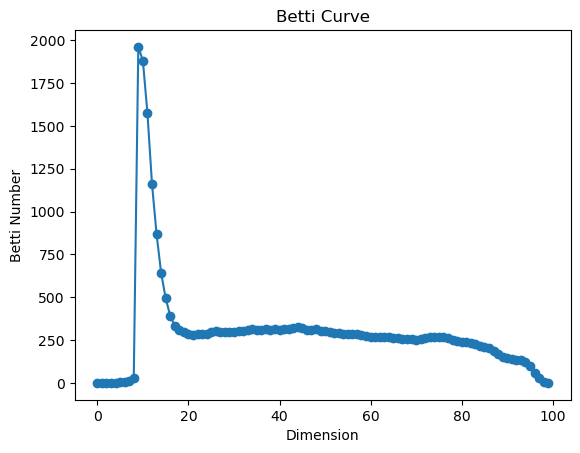

In [43]:
bc = gd.representations.vector_methods.BettiCurve() 

bc_0 = bc(persistence_0_no_inf)
bc_1 = bc(persistence_1_no_inf)

plt.plot(range(bc_1.shape[0]) , bc_1, marker='o')
plt.xlabel('Dimension')
plt.ylabel('Betti Number')
plt.title('Betti Curve')
plt.show()

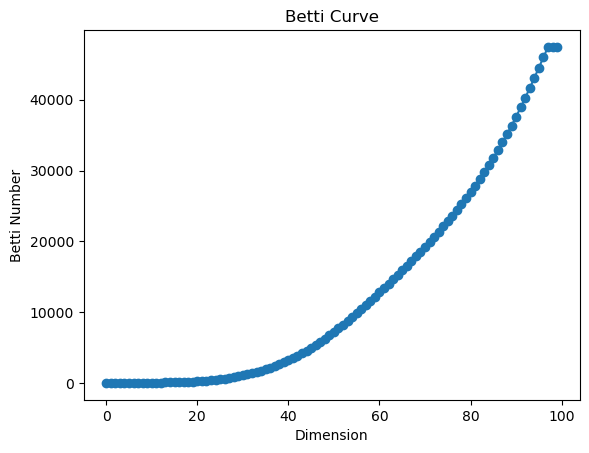

In [19]:
# Extract Betti numbers and plot the Betti curve
betti_numbers = bc_0.cumsum(0)  # Cumulative sum along the 0-axis (dimension)
dimensions = range(bc_0.shape[0])  # Dimensions of the Betti numbers

plt.plot(dimensions, betti_numbers, marker='o')
plt.xlabel('Dimension')
plt.ylabel('Betti Number')
plt.title('Betti Curve')
plt.show()

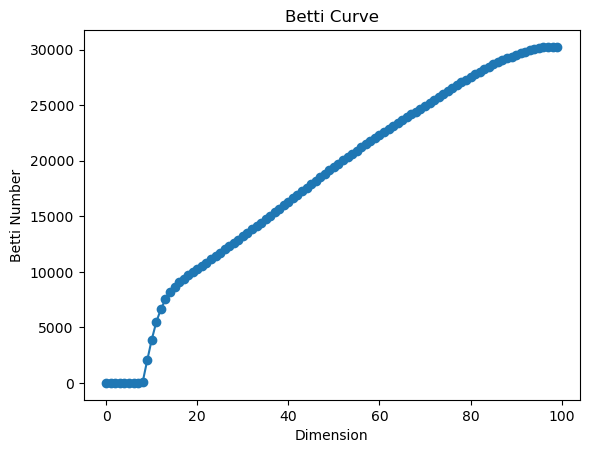

In [20]:
# Extract Betti numbers and plot the Betti curve
betti_numbers = bc_1.cumsum(0)  # Cumulative sum along the 0-axis (dimension)
dimensions = range(bc_1.shape[0])  # Dimensions of the Betti numbers

plt.plot(dimensions, betti_numbers, marker='o')
plt.xlabel('Dimension')
plt.ylabel('Betti Number')
plt.title('Betti Curve')
plt.show()

##  Landscapes
https://gudhi.inria.fr/python/3.4.0/_modules/gudhi/representations/vector_methods.html#Landscape

In [21]:
lc = gd.representations.Landscape(num_landscapes=2,resolution=10)

lc_0 = lc(persistence_0_no_inf)
lc_1 = lc(persistence_1_no_inf)
lc_0

array([0.03514207, 0.07028415, 0.10542622, 0.14056829, 0.17571036,
       0.16669323, 0.13155115, 0.09640908, 0.06344212, 0.03236411,
       0.02520764, 0.06034971, 0.09549178, 0.13063386, 0.16577593,
       0.16669323, 0.13155115, 0.09640908, 0.06126701, 0.03127101])

Area under the curve: 1.9490346460270682


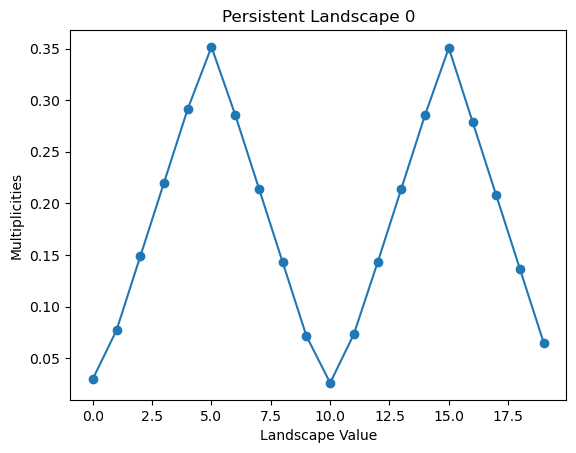

In [22]:
plt.plot(lc_1, marker='o')
plt.xlabel('Landscape Value')
plt.ylabel('Multiplicities')
plt.title('Persistent Landscape 0')

area_under_curve = np.trapz(lc_0, dx=1)  # dx is the spacing between points along the x-axis
print("Area under the curve:", area_under_curve)

plt.show()

##  Silhouette
https://gudhi.inria.fr/python/latest/_modules/gudhi/representations/vector_methods.html#Silhouette

In [28]:
s = gd.representations.Silhouette()

resolution=100
p = 2
s2 = gd.representations.Silhouette(weight = lambda x: np.power(x[1]-x[0], p), resolution=resolution)

s_0 = s(persistence_0_no_inf)
s_1 = s(persistence_1_no_inf)
s2_0 = s2(persistence_0_no_inf)
s2_1 = s2(persistence_1_no_inf)

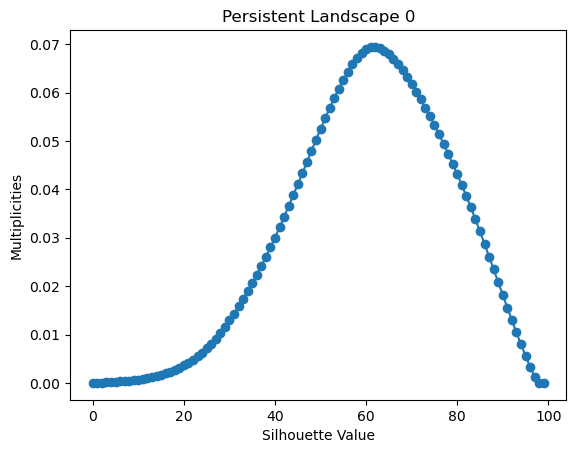

In [29]:
plt.plot(s2_0, marker='o')
plt.xlabel('Silhouette Value')
plt.ylabel('Multiplicities')
plt.title('Persistent Landscape 0')

plt.show()

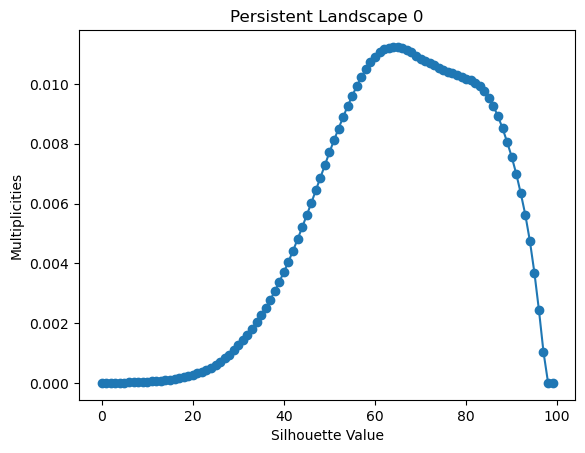

In [30]:
plt.plot(s_0, marker='o')
plt.xlabel('Silhouette Value')
plt.ylabel('Multiplicities')
plt.title('Persistent Landscape 0')

plt.show()

## Pipeline

In [7]:
%matplotlib inline

def compute_TDA(grayscale_image, display_results = False):
    flat_grayscale_image = grayscale_image.flatten()
    # Create CubicalComplex
    cc = gd.CubicalComplex(dimensions=grayscale_image.shape, top_dimensional_cells=flat_grayscale_image)

    # Persistencia
    persistence = cc.persistence()

    # Descriptors
    persistence_0 = cc.persistence_intervals_in_dimension(0)  # intervals de persistencia de dimensio 0
    persistence_1 = cc.persistence_intervals_in_dimension(1)  # intervals de persistencia de dimensio 1

    persistence_0_no_inf = np.array([bars for bars in persistence_0 if bars[1] != np.inf])
    persistence_1_no_inf = np.array([bars for bars in persistence_1 if bars[1] != np.inf])

    # Persistencia total
    pt_0 = np.sum(
        np.fromiter((interval[1] - interval[0] for interval in persistence_0_no_inf), dtype=np.dtype(np.float64)))
    pt_1 = np.sum(
        np.fromiter((interval[1] - interval[0] for interval in persistence_1_no_inf), dtype=np.dtype(np.float64)))

    # Vida mitja
    al_0 = 0
    al_1 = 0

    # Desviacio estandard
    sd_0 = 0
    sd_1 = 0

    # Entropia
    PE = gd.representations.Entropy()
    pe_0 = 0
    pe_1 = 0

    # Betti numbers
    bc = gd.representations.vector_methods.BettiCurve()
    bc_0 = np.zeros(100)
    bc_1 = np.zeros(100)

    # Landscapes
    num_landscapes = 10
    points_per_landscape = 100
    lc = gd.representations.Landscape(num_landscapes=num_landscapes, resolution=points_per_landscape)
    lc_0 = np.zeros(100)
    lc_1 = np.zeros(100)
    area_under_lc_0 = np.zeros(num_landscapes)
    area_under_lc_1 = np.zeros(num_landscapes)

    # Silhouettes
    p = 2
    resolution = 100
    s = gd.representations.Silhouette()
    s2 = gd.representations.Silhouette(weight=lambda x: np.power(x[1] - x[0], p), resolution=resolution)
    s_0 = np.zeros(100)
    s_1 = np.zeros(100)
    s2_0 = np.zeros(100)
    s2_1 = np.zeros(100)
    area_under_s_0 = 0
    area_under_s_1 = 0
    area_under_s2_0 = 0
    area_under_s2_1 = 0

    if (persistence_0_no_inf.size > 0):
        al_0 = pt_0 / len(persistence_0_no_inf)
        sd_0 = np.std([(start + end) / 2 for start, end in persistence_0_no_inf])
        pe_0 = PE.fit_transform([persistence_0_no_inf])[0][0]
        bc_0 = bc(persistence_0_no_inf)
        lc_0 = lc(persistence_0_no_inf)
        reshaped_landscapes_0 = lc_0.reshape(num_landscapes,points_per_landscape)
        for i in range(num_landscapes):
            area_under_lc_0[i] = np.trapz(reshaped_landscapes_0[i], dx=1)
        s_0 = s(persistence_0_no_inf)
        s2_0 = s2(persistence_0_no_inf)
        area_under_s_0 = np.trapz(s_0, dx=1)
        area_under_s2_0 = np.trapz(s2_0, dx=1)

    if (persistence_1_no_inf.size > 0):
        al_1 = pt_1 / len(persistence_1_no_inf)
        sd_1 = np.std([(start + end) / 2 for start, end in persistence_1_no_inf])
        pe_1 = PE.fit_transform([persistence_1_no_inf])[0][0]
        bc_1 = bc(persistence_1_no_inf)
        lc_1 = lc(persistence_1_no_inf)
        reshaped_landscapes_1 = lc_1.reshape(num_landscapes, points_per_landscape)
        for i in range(num_landscapes):
            area_under_lc_1[i] = np.trapz(reshaped_landscapes_1[i], dx=1)
        s_1 = s(persistence_1_no_inf)
        s2_1 = s2(persistence_1_no_inf)
        area_under_s_1 = np.trapz(s_1, dx=1)
        area_under_s2_1 = np.trapz(s2_1, dx=1)

    if(display_results):
        # Very fancy print
        fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(8, 40))

        axes[0, 0].imshow(grayscale_image, cmap='gray')
        axes[0, 0].set_title('Image')
        
        gd.plot_persistence_diagram(persistence, legend=True, axes=axes[0, 1])
        axes[0, 1].set_title('Persistence diagram')

        gd.plot_persistence_barcode(persistence_0, axes=axes[1,0])
        axes[1, 0].set_title('Persistence barcode 0')
        
        gd.plot_persistence_barcode(persistence_1, axes=axes[1,1])
        axes[1, 1].set_title('Persistence barcode 1')
        
        axes[2, 0].plot(bc_0, marker='o')
        axes[2, 0].set_title('Betti numbers 0 ')
        
        axes[2, 1].plot(bc_1, marker='o')
        axes[2, 1].set_title('Betti numbers 1')
        
        axes[3, 0].plot(bc_0.cumsum(0), marker='o')
        axes[3, 0].set_title('Betti numbers 0 (cum sum)')
        
        axes[3, 1].plot(bc_1.cumsum(0), marker='o')
        axes[3, 1].set_title('Betti numbers 1 (cum sum)')
        
        axes[4, 0].plot(lc_0, marker='o')
        axes[4, 0].set_title('Landscape 0')
        
        axes[4, 1].plot(lc_1, marker='o')
        axes[4, 1].set_title('Landscape 1')
        
        axes[5, 0].plot(s_0, marker='o')
        axes[5, 0].set_title('Silhouette 0 - default')

        axes[5, 1].plot(s_1, marker='o')
        axes[5, 1].set_title('Silhouette 1 - default')
        
        axes[6, 0].plot(s2_0, marker='o')
        axes[6, 0].set_title('Silhouette 0 - quadratic')

        axes[6, 1].plot(s2_1, marker='o')
        axes[6, 1].set_title('Silhouette 1 - quadratic')

        plt.tight_layout()
        plt.show()

    return {'pt': [pt_0, pt_1], 'al': [al_0, al_1], 'sd': [sd_0, sd_1], 'pe': [pe_0, pe_1], 
                               'bn': [bc_0, bc_1], 'lc': [area_under_lc_0, area_under_lc_1], 
                               's': [area_under_s_0, area_under_s_1], 's2': [area_under_s2_0, area_under_s2_1]}


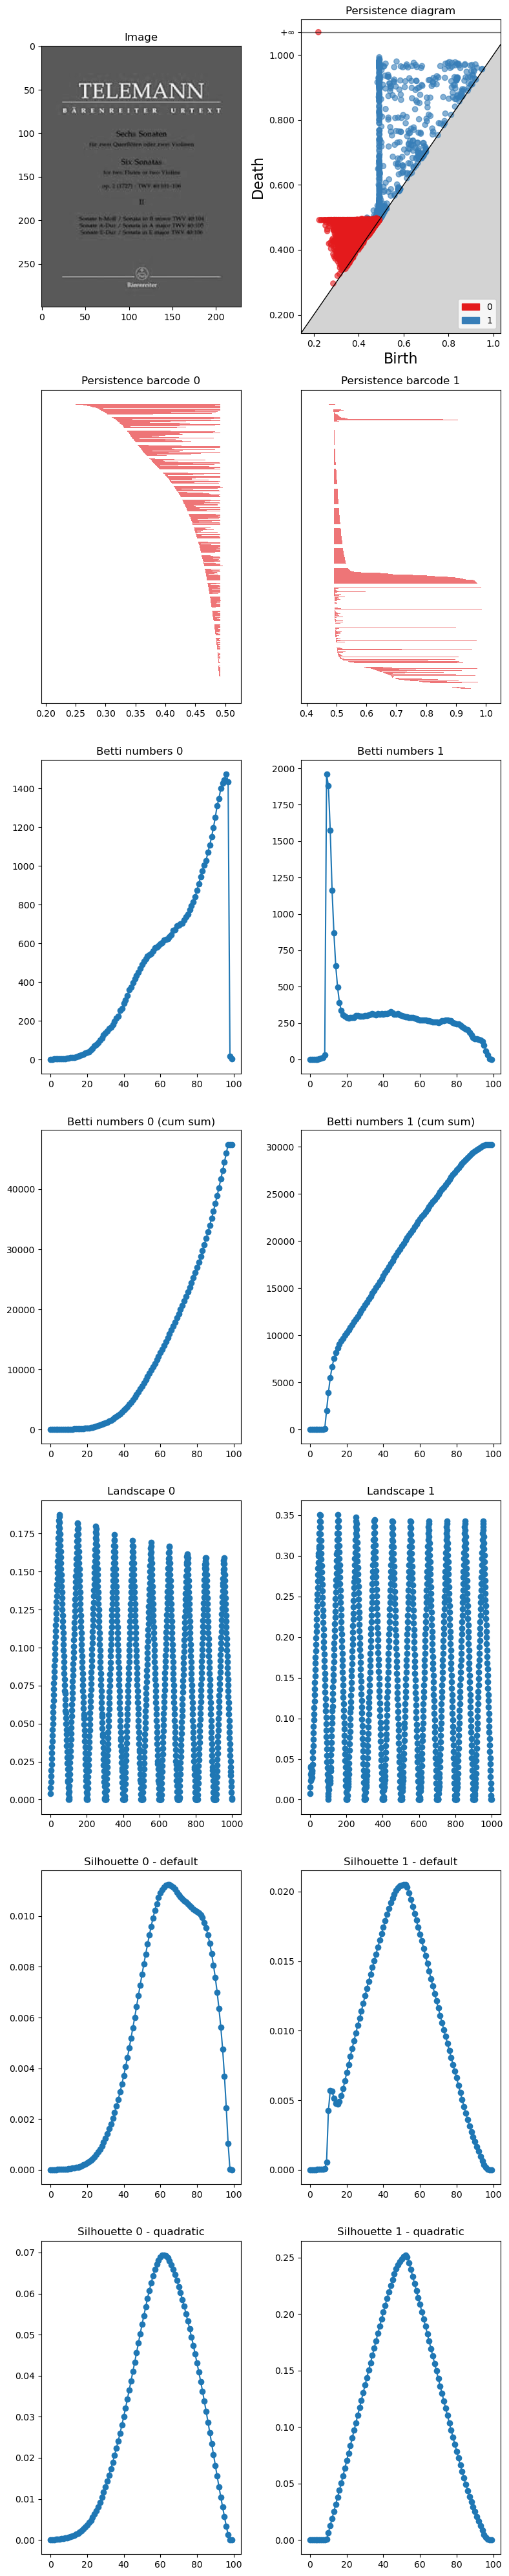

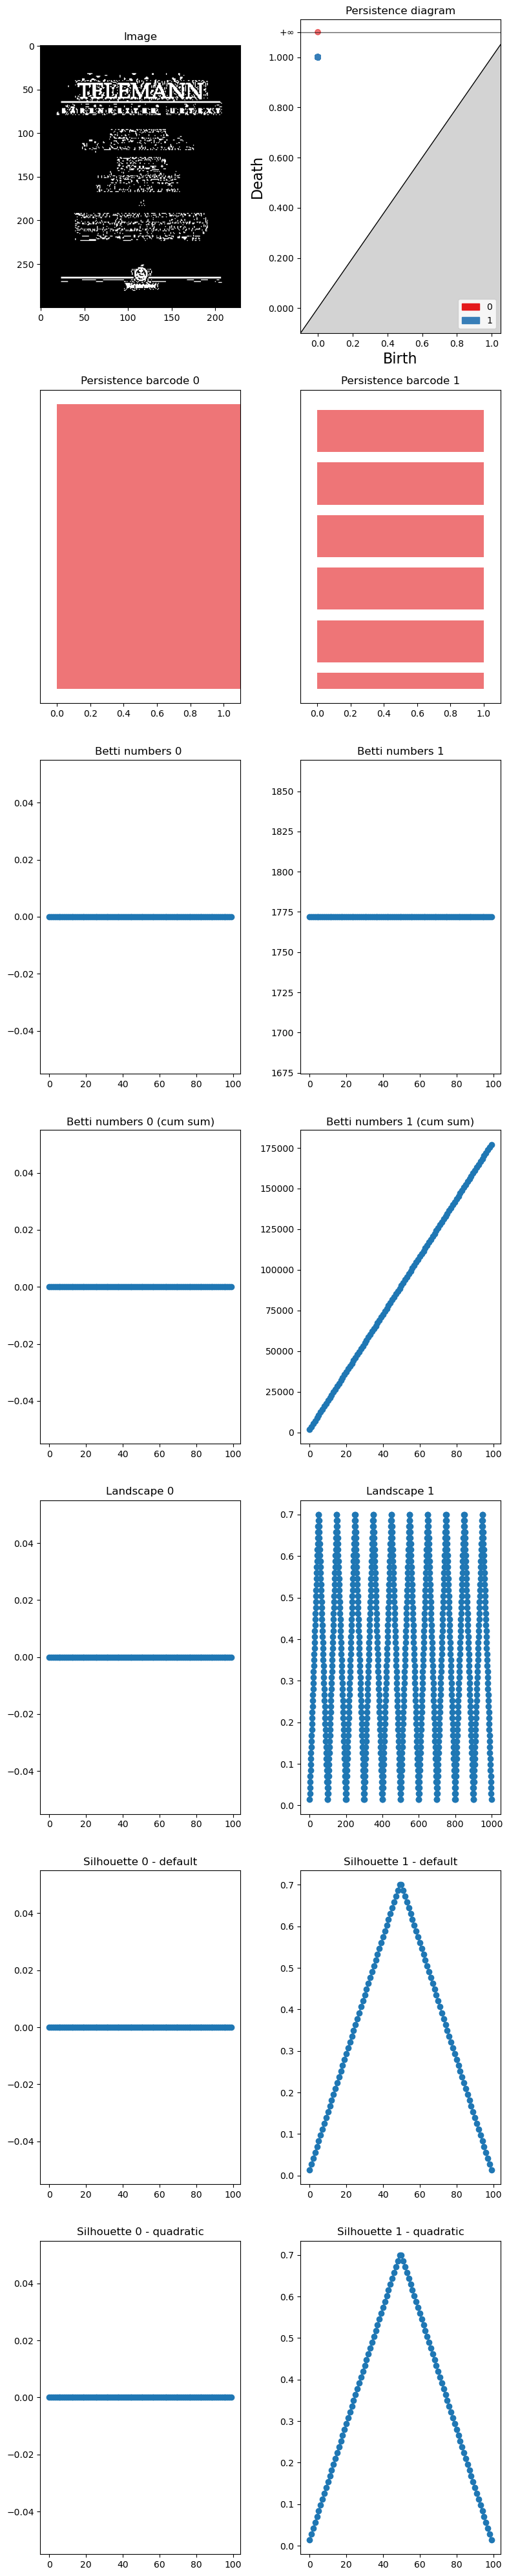

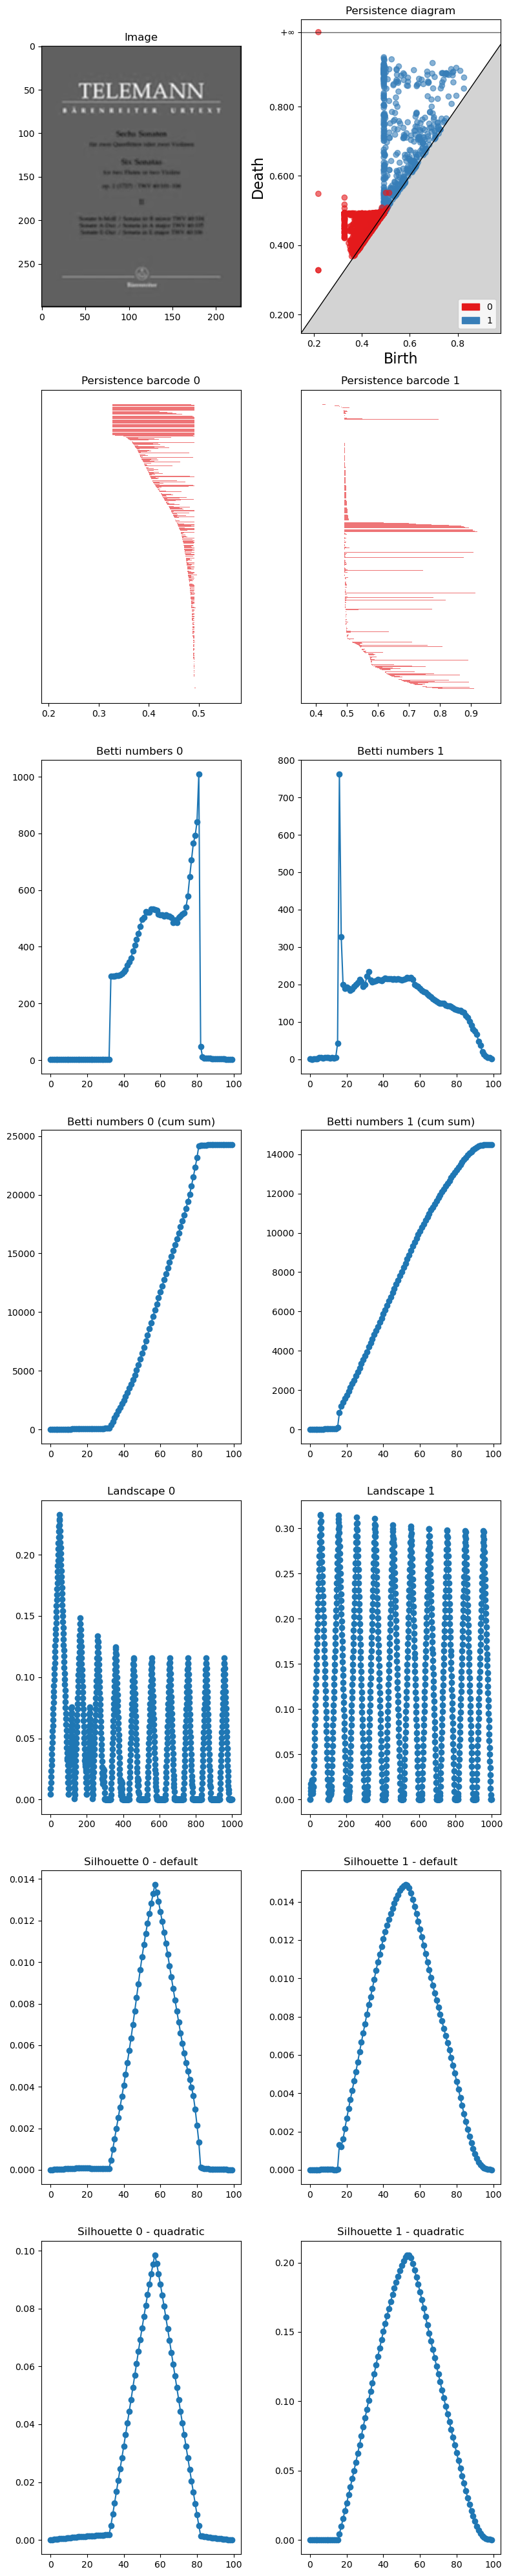

In [8]:
all_descriptors = dict()

i = 1 #num of images to analyze

normal = True
binarized = True
convolved = True

with open("./Musical_instruments_meta.json", 'r') as f:
    for line in f.readlines():
        json_line = json.loads(line)
        id = json_line["asin"]
        img_link = json_line["imUrl"]
        
        # 1. image processing
        image = io.imread(img_link)
        grayscale_image = rgb2gray(image)
        
        # Afegir descriptor    
        if(normal):
            all_descriptors[id + "normal"] = compute_TDA(grayscale_image, True)
        
        if(binarized):
            treshold = 0.5
            binarized_image = grayscale_image > treshold
            all_descriptors[id + "bin"] = compute_TDA(binarized_image, True)
        
        if(convolved):
            convolve = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]])
            convolved_image = ndimage.convolve(grayscale_image, convolve, mode='constant', cval=0.0)
            convolved_image = convolved_image / 9
            all_descriptors[id + "conv"] = compute_TDA(convolved_image, True)
        
        i -= 1
        if i == 0:
            break

    f.close()
    
    #print(all_descriptors)

areas: 33.01109839988749 total: 33.79747827948851
[3.45715015 2.4633758  2.33406593 2.27743165 2.23253856 2.17764149
 2.13825365 2.09495935 2.06549833 2.02254562 2.00155501 1.97552917
 1.94753913 1.92136128 1.90165327]


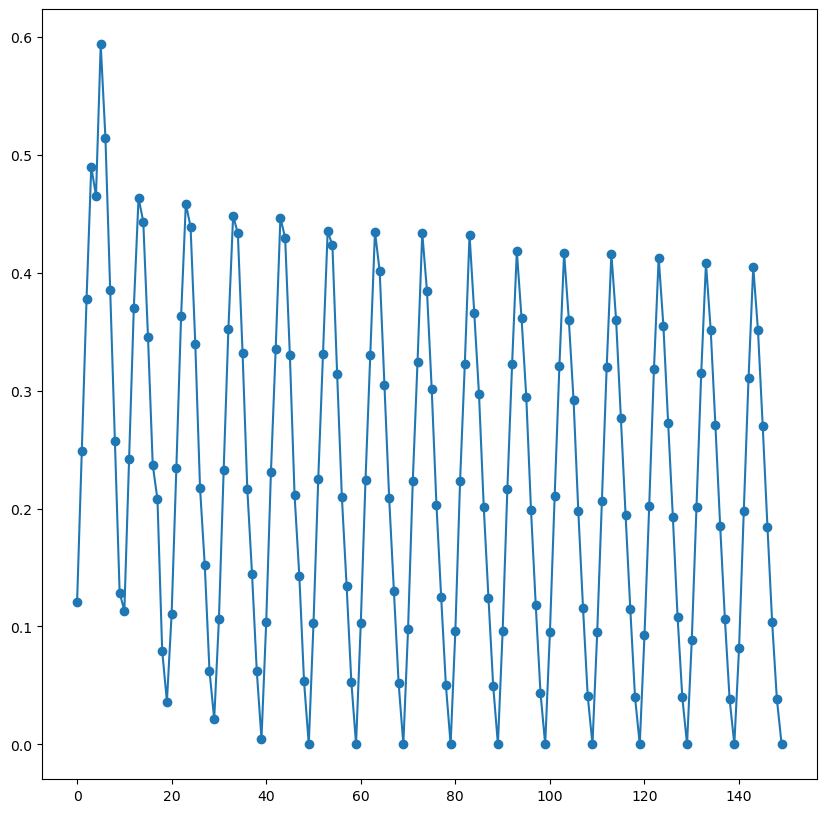

In [27]:
%matplotlib inline
def betti(grayscale_image):
    flat_grayscale_image = grayscale_image.flatten()
    # Create CubicalComplex
    cc = gd.CubicalComplex(dimensions=grayscale_image.shape, top_dimensional_cells=flat_grayscale_image)

    # Persistencia
    persistence = cc.persistence()

    # Descriptors
    persistence_0 = cc.persistence_intervals_in_dimension(0)  # intervals de persistencia de dimensio 0
    persistence_1 = cc.persistence_intervals_in_dimension(1)  # intervals de persistencia de dimensio 1

    persistence_0_no_inf = np.array([bars for bars in persistence_0 if bars[1] != np.inf])
    persistence_1_no_inf = np.array([bars for bars in persistence_1 if bars[1] != np.inf])

    lc = gd.representations.Landscape(num_landscapes=15, resolution=10)
    lc_0 = lc(persistence_0_no_inf)
    reshaped_landscapes = lc_0.reshape(15, 10)

    areas = np.zeros(15)
    for i in range(15):
        areas[i] = np.trapz(reshaped_landscapes[i], dx=1)
    aux = sum(areas)
    area_under_lc_0 = np.trapz(lc_0, dx=1)
    print('areas:', aux, 'total:', area_under_lc_0)
    print(areas)
    
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
        
    axes.plot(lc_0, marker='o')
    plt.show()

img_link = "http://ecx.images-amazon.com/images/I/51B4TR3e8ML._SY300_.jpg"

# 1. image processing
image = io.imread(img_link)
grayscale_image = rgb2gray(image)

# Afegir descriptor    
betti(grayscale_image)
    

areas: 7.15916802295376 total: 7.508144806705292
[1.90962251 1.58961091 0.92443508 0.80129794 0.68035374 0.48907354
 0.34550621 0.18298542 0.07327106 0.04708918 0.0343783  0.0230987
 0.01948181 0.01948181 0.01948181]


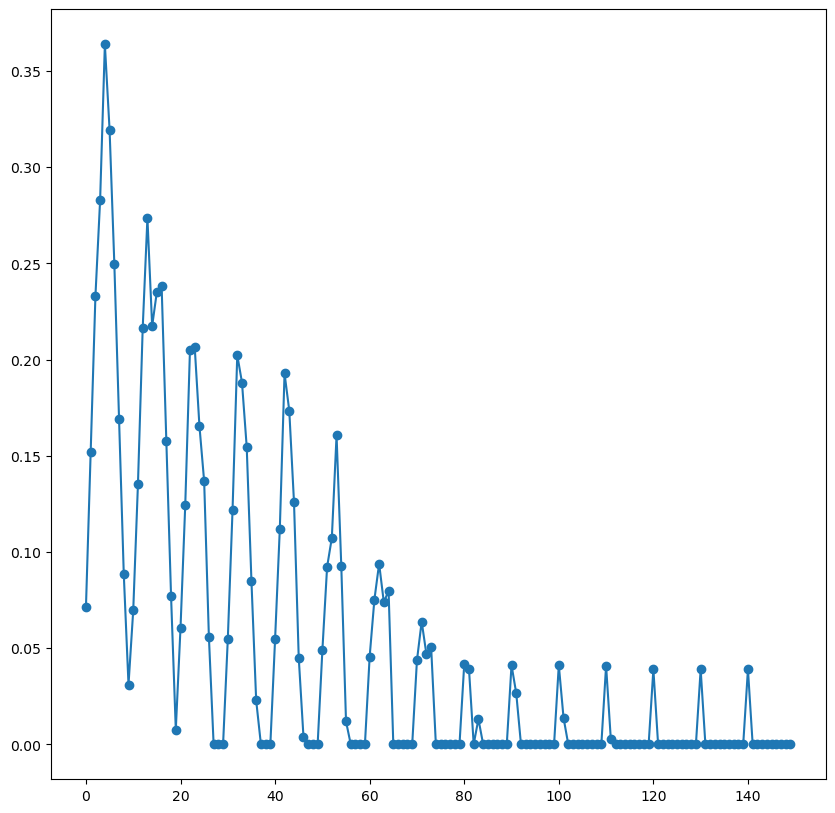

In [28]:
img_link = "http://ecx.images-amazon.com/images/I/41SXCAzspfL._SY300_.jpg"

# 1. image processing
image = io.imread(img_link)
grayscale_image = rgb2gray(image)

# Afegir descriptor    
betti(grayscale_image)
    